In [ ]:
##get_ipython().kernel.do_shutdown(restart=True)       # Tor Restart the Kernal explicitly

In [1]:
!nvidia-smi  # this should display information about available GPUs
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
import cudf  # this should work without any errors
!pip install plotly-express
%load_ext cudf.pandas

Fri May  3 16:17:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18,8)},style='darkgrid')
from time import time
import re
import string
import nltk
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Step 1: Data Preparation
import pandas as pd

# Load the dataset
t20_data = pd.read_csv('T-20 World cup 2022.csv')

In [12]:
# Data Cleaning

# Check for missing values

missing_values = t20_data.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
comment_id              0
match_id                0
match_name              0
home_team               1
away_team               1
current_innings         1
innings_id              1
over                    1
ball                    1
runs                    1
shortText               1
isBoundary              1
isWide                  1
isNoball                1
batsman1_id             1
batsman1_name           1
batsman1_runs           1
batsman1_balls          1
bowler1_id              1
bowler1_name            1
bowler1_overs           1
bowler1_maidens         1
bowler1_runs            1
bowler1_wkts            1
batsman2_id             1
batsman2_name           1
batsman2_runs           1
batsman2_balls          1
bowler2_id            241
bowler2_name          241
bowler2_overs         241
bowler2_maidens       241
bowler2_runs          241
bowler2_wkts          241
wicket_id            4281
wkt_batsman_name     4281
wkt_bowler_name      4281
wkt_batsman_runs     4

In [13]:
# Handle missing values

# Drop rows with missing values for columns where a single missing value is negligible
t20_data.dropna(subset=['home_team', 'away_team', 'current_innings', 'innings_id', 'over', 'ball', 'runs', 'shortText',
                        'isBoundary', 'isWide', 'isNoball', 'batsman1_id', 'batsman1_name', 'batsman1_runs', 'batsman1_balls',
                        'bowler1_id', 'bowler1_name', 'bowler1_overs', 'bowler1_maidens', 'bowler1_runs', 'bowler1_wkts',
                        'batsman2_id', 'batsman2_name', 'batsman2_runs', 'batsman2_balls', 'isRetiredHurt', 'text'], inplace=True)

# For columns with a significant number of missing values, consider dropping or imputing them based on domain knowledge or specific requirements
# Example:
# Drop columns with a large number of missing values
t20_data.drop(columns=['bowler2_id', 'bowler2_name', 'bowler2_overs', 'bowler2_maidens', 'bowler2_runs', 'bowler2_wkts'], inplace=True)

# For remaining columns with missing values, consider imputation strategies such as mean, median, or mode
# Example:
# Impute missing values in numeric columns with mean
numeric_columns = ['wicket_id', 'wkt_batsman_runs', 'wkt_batsman_balls']
t20_data[numeric_columns] = t20_data[numeric_columns].fillna(t20_data[numeric_columns].mean())

# Impute missing values in categorical columns with mode
categorical_columns = ['wkt_batsman_name', 'wkt_bowler_name', 'wkt_text', 'preText', 'postText']
for column in categorical_columns:
    t20_data[column] = t20_data[column].fillna(t20_data[column].mode()[0])

# After handling missing values, verify if there are any remaining missing values
remaining_missing_values = t20_data.isnull().sum()
print("Remaining Missing Values:")
print(remaining_missing_values)


Remaining Missing Values:
comment_id           0
match_id             0
match_name           0
home_team            0
away_team            0
current_innings      0
innings_id           0
over                 0
ball                 0
runs                 0
shortText            0
isBoundary           0
isWide               0
isNoball             0
batsman1_id          0
batsman1_name        0
batsman1_runs        0
batsman1_balls       0
bowler1_id           0
bowler1_name         0
bowler1_overs        0
bowler1_maidens      0
bowler1_runs         0
bowler1_wkts         0
batsman2_id          0
batsman2_name        0
batsman2_runs        0
batsman2_balls       0
wicket_id            0
wkt_batsman_name     0
wkt_bowler_name      0
wkt_batsman_runs     0
wkt_batsman_balls    0
wkt_text             0
isRetiredHurt        0
text                 0
preText              0
postText             0
dtype: int64


In [14]:
t20_data.head()

,comment_id,match_id,match_name,home_team,away_team,current_innings,innings_id,over,ball,runs,...,wicket_id,wkt_batsman_name,wkt_bowler_name,wkt_batsman_runs,wkt_batsman_balls,wkt_text,isRetiredHurt,text,preText,postText
0,130,1298179,ENG v PAK,PAK,ENG,PAK,1,1,1,0,...,525829.790514,Babar Azam,Shaheen Shah Afridi,15.996047,14.146245,A Balbirnie b Cummins 6 (11m 7b 0x4 1x6) SR: ...,False,"short again, and he gets some extra bounce on ...",<p>Around</p>,"<p><b>Welcome to the Cricinfoverse! <a href=""h..."
1,120,1298179,ENG v PAK,PAK,ENG,PAK,1,1,1,1,...,525829.790514,Babar Azam,Shaheen Shah Afridi,15.996047,14.146245,A Balbirnie b Cummins 6 (11m 7b 0x4 1x6) SR: ...,False,and he'll have to bowl another free-hit after ...,<p>Free-hit</p>,"<p><b>Welcome to the Cricinfoverse! <a href=""h..."
2,110,1298179,ENG v PAK,PAK,ENG,PAK,1,1,1,1,...,525829.790514,Babar Azam,Shaheen Shah Afridi,15.996047,14.146245,A Balbirnie b Cummins 6 (11m 7b 0x4 1x6) SR: ...,False,"full, and a hint of shape away from off stump....","<p><b>6.58pm</b> Thanks, Andrew M. The MCG is ...","<p><b>Welcome to the Cricinfoverse! <a href=""h..."
3,140,1298179,ENG v PAK,PAK,ENG,PAK,1,1,2,2,...,525829.790514,Babar Azam,Shaheen Shah Afridi,15.996047,14.146245,A Balbirnie b Cummins 6 (11m 7b 0x4 1x6) SR: ...,False,"shortish, angling down leg, gloves a pull down...",<p>Around</p>,"<p><b>Welcome to the Cricinfoverse! <a href=""h..."
4,150,1298179,ENG v PAK,PAK,ENG,PAK,1,1,3,0,...,525829.790514,Babar Azam,Shaheen Shah Afridi,15.996047,14.146245,A Balbirnie b Cummins 6 (11m 7b 0x4 1x6) SR: ...,False,"length ball close to off stump, straightens a ...",<p>Around</p>,"<p><b>Welcome to the Cricinfoverse! <a href=""h..."


In [15]:
t20_data.tail()

,comment_id,match_id,match_name,home_team,away_team,current_innings,innings_id,over,ball,runs,...,wicket_id,wkt_batsman_name,wkt_bowler_name,wkt_batsman_runs,wkt_batsman_balls,wkt_text,isRetiredHurt,text,preText,postText
4528,16010,1298158,PAK v ZIM,ZIM,PAK,ZIM,1,7,1,1,...,525829.790514,Babar Azam,Shaheen Shah Afridi,15.996047,14.146245,A Balbirnie b Cummins 6 (11m 7b 0x4 1x6) SR: ...,False,"over the wicket, back of a length, jabbed to t...","<p>A productive Powerplay for Zimbabwe, but th...","<p><b>Welcome to the Cricinfoverse! <a href=""h..."
4529,16020,1298158,PAK v ZIM,ZIM,PAK,ZIM,1,7,2,0,...,525829.790514,Babar Azam,Shaheen Shah Afridi,15.996047,14.146245,A Balbirnie b Cummins 6 (11m 7b 0x4 1x6) SR: ...,False,"over the wicket, wide of off, zipping past a f...",<p>Around</p>,"<p><b>Welcome to the Cricinfoverse! <a href=""h..."
4530,16030,1298158,PAK v ZIM,ZIM,PAK,ZIM,1,7,3,0,...,525829.790514,Babar Azam,Shaheen Shah Afridi,15.996047,14.146245,A Balbirnie b Cummins 6 (11m 7b 0x4 1x6) SR: ...,False,"beaten all ends up! Angling in, straightening ...",<p>Around</p>,"<p>Samad Naqvi: ""Wasim is so important in thes..."
4531,16040,1298158,PAK v ZIM,ZIM,PAK,ZIM,1,7,4,0,...,525829.790514,Babar Azam,Shaheen Shah Afridi,15.996047,14.146245,A Balbirnie b Cummins 6 (11m 7b 0x4 1x6) SR: ...,False,"chipped in the air, didn't know much about tha...",<p>Around</p>,"<p><b>Welcome to the Cricinfoverse! <a href=""h..."
4532,16050,1298158,PAK v ZIM,ZIM,PAK,ZIM,1,7,5,1,...,525829.790514,Babar Azam,Shaheen Shah Afridi,15.996047,14.146245,A Balbirnie b Cummins 6 (11m 7b 0x4 1x6) SR: ...,False,"climbs through the pull, to the leg side, unde...",<p>Around</p>,"<p><b>Welcome to the Cricinfoverse! <a href=""h..."


In [16]:
t20_data.describe()

,comment_id,match_id,innings_id,over,ball,runs,batsman1_id,batsman1_runs,batsman1_balls,bowler1_id,bowler1_overs,bowler1_maidens,bowler1_runs,bowler1_wkts,batsman2_id,batsman2_runs,batsman2_balls,wicket_id,wkt_batsman_runs,wkt_batsman_balls
count,4533.000000,4.533000e+03,4533.000000,4533.000000,4533.000000,4533.000000,4.533000e+03,4533.000000,4533.000000,4.533000e+03,4533.000000,4533.000000,4533.000000,4533.000000,4.533000e+03,4533.000000,4533.000000,4.533000e+03,4533.000000,4533.000000
mean,85048.347673,1.298170e+06,1.473638,10.067946,3.485109,1.226781,4.766042e+05,16.041915,13.222369,6.001045e+05,1.666027,0.030885,12.830576,0.514229,4.659638e+05,14.936245,12.375028,5.258298e+05,15.996047,14.146245
std,78803.254195,5.586566e+00,0.499360,5.613490,1.706527,1.505277,2.848912e+05,16.351515,11.201515,3.284905e+05,1.107123,0.173024,9.744257,0.776465,2.822800e+05,15.840490,10.981575,7.431047e+04,3.956599,2.729638
min,110.000000,1.298158e+06,1.000000,1.000000,1.000000,0.000000,5.334000e+03,0.000000,0.000000,8.917000e+03,0.000000,0.000000,0.000000,0.000000,5.334000e+03,0.000000,0.000000,5.334000e+03,0.000000,1.000000
25%,18020.000000,1.298165e+06,1.000000,5.000000,2.000000,0.000000,2.995720e+05,4.000000,4.000000,3.309020e+05,0.500000,0.000000,5.000000,0.000000,2.995720e+05,2.000000,4.000000,5.258298e+05,15.996047,14.146245
50%,28060.000000,1.298170e+06,1.000000,10.000000,3.000000,1.000000,3.797740e+05,11.000000,10.000000,5.264410e+05,1.400000,0.000000,11.000000,0.000000,3.791400e+05,10.000000,9.000000,5.258298e+05,15.996047,14.146245
75%,118040.000000,1.298175e+06,2.000000,15.000000,5.000000,1.000000,6.290580e+05,24.000000,19.000000,9.229430e+05,2.400000,0.000000,19.000000,1.000000,6.290580e+05,23.000000,18.000000,5.258298e+05,15.996047,14.146245
max,219070.000000,1.298179e+06,2.000000,20.000000,6.000000,7.000000,1.205559e+06,104.000000,63.000000,1.193548e+06,4.000000,1.000000,57.000000,4.000000,1.205559e+06,104.000000,63.000000,1.205559e+06,71.000000,55.000000


In [17]:
t20_data.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 4533 entries, 0 to 4532
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   comment_id         4533 non-null   int64
 1   match_id           4533 non-null   int64
 2   match_name         4533 non-null   object
 3   home_team          4533 non-null   object
 4   away_team          4533 non-null   object
 5   current_innings    4533 non-null   object
 6   innings_id         4533 non-null   int64
 7   over               4533 non-null   int64
 8   ball               4533 non-null   int64
 9   runs               4533 non-null   int64
 10  shortText          4533 non-null   object
 11  isBoundary         4533 non-null   bool
 12  isWide             4533 non-null   bool
 13  isNoball           4533 non-null   bool
 14  batsman1_id        4533 non-null   int64
 15  batsman1_name      4533 non-null   object
 16  batsman1_runs      4533 non-null   int64
 17  batsman1_balls

# 1. **Data Exploration**


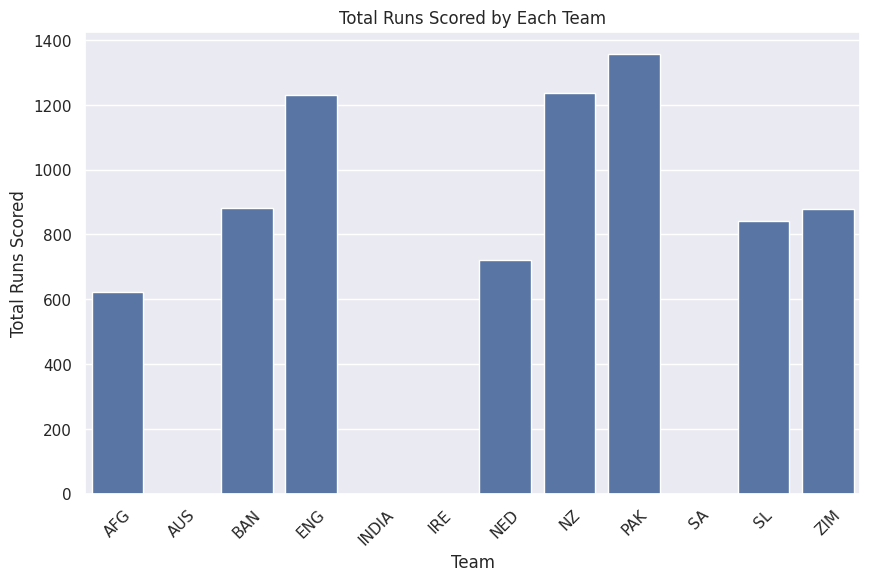

In [19]:
# Question 1: Trends in team performances throughout the tournament
team_performance_trend = t20_data.groupby('home_team')['runs'].sum() + t20_data.groupby('away_team')['runs'].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=team_performance_trend.index, y=team_performance_trend.values)
plt.title('Total Runs Scored by Each Team')
plt.xlabel('Team')
plt.ylabel('Total Runs Scored')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Question 2: Patterns in player performances
top_scorers = t20_data.groupby('batsman1_name')['runs'].sum().nlargest(10)
leading_wicket_takers = t20_data.groupby('bowler1_name')['bowler1_wkts'].sum().nlargest(10)

print("\nTop Scorers:")
print(top_scorers)
print("\nLeading Wicket-takers:")
print(leading_wicket_takers)


Top Scorers:
batsman1_name
Jos Buttler              220
Glenn Phillips           196
Alex Hales               189
Suryakumar Yadav         170
Mohammad Rizwan          161
Virat Kohli              159
Kane Williamson          156
Najmul Hossain Shanto    148
Babar Azam               123
KL Rahul                 118
Name: runs, dtype: int64

Leading Wicket-takers:
bowler1_name
Shaheen Shah Afridi    115
Arshdeep Singh          90
Shadab Khan             90
Lungi Ngidi             85
Sam Curran              80
Trent Boult             71
Brandon Glover          69
Anrich Nortje           64
Blessing Muzarabani     63
Mitchell Santner        62
Name: bowler1_wkts, dtype: int64


In [21]:
# Question 3: Correlation between key events and match outcomes
key_events_correlation = t20_data[['runs', 'isBoundary', 'isNoball', 'isWide', 'bowler1_wkts']].corrwith(t20_data['runs'])
print("\nCorrelation between Key Events and Runs Scored:")
print(key_events_correlation)


Correlation between Key Events and Runs Scored:
runs            1.000000
isBoundary      0.864532
isNoball        0.054473
isWide         -0.009694
bowler1_wkts   -0.086583
dtype: float64


In [22]:
# Question 4: Team performances across different match formats
team_performance_format = t20_data.groupby(['home_team', 'current_innings'])['runs'].sum().unstack(fill_value=0)
print("\nTeam Performance by Match Format:")
print(team_performance_format)


Team Performance by Match Format:
current_innings  AFG   SL  AUS  IRE  BAN  PAK  ZIM  ENG   NZ  INDIA   SA  NED
home_team                                                                    
AFG              143  148    0    0    0    0    0    0    0      0    0    0
AUS              164    0  329  137    0    0    0    0    0      0    0    0
BAN                0    0    0    0  277  128  147    0    0      0    0    0
ENG                0    0    0    0    0    0    0  178  159      0    0    0
INDIA              0    0    0    0  145    0  115  170    0    665  137    0
NED                0    0    0    0    0   95    0    0    0      0  141  249
NZ                 0  102    0  150    0  153    0    0  495      0    0    0
PAK                0    0    0    0    0  317    0  138    0      0  108    0
SL                 0  141    0    0    0    0    0  144    0      0    0    0
ZIM                0    0    0    0    0    0  166    0    0      0    0  120


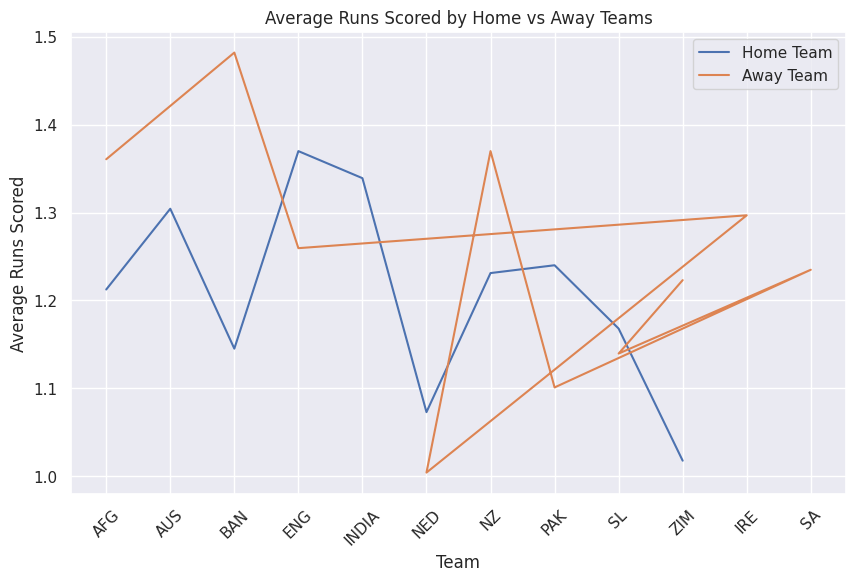

In [23]:
# Question 6: Are there any noticeable trends in team performance based on home or away matches?
home_team_performance = t20_data.groupby('home_team')['runs'].mean()
away_team_performance = t20_data.groupby('away_team')['runs'].mean()
plt.figure(figsize=(10, 6))
plt.plot(home_team_performance.index, home_team_performance.values, label='Home Team')
plt.plot(away_team_performance.index, away_team_performance.values, label='Away Team')
plt.title('Average Runs Scored by Home vs Away Teams')
plt.xlabel('Team')
plt.ylabel('Average Runs Scored')
plt.legend()
plt.xticks(rotation=45)
plt.show()


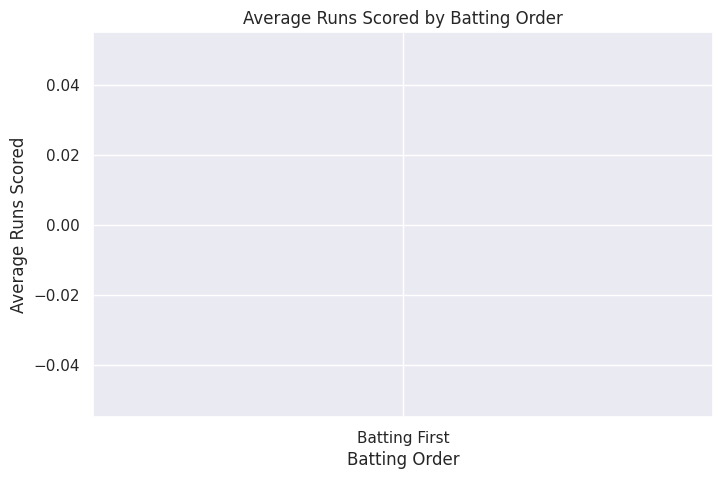

In [24]:
# Question 7: How do match outcomes vary depending on batting first or second?
batting_first_outcomes = t20_data[t20_data['current_innings'] == '1st Innings']['runs'].mean()
batting_second_outcomes = t20_data[t20_data['current_innings'] == '2nd Innings']['runs'].mean()
plt.figure(figsize=(8, 5))
plt.bar(['Batting First', 'Batting Second'], [batting_first_outcomes, batting_second_outcomes])
plt.title('Average Runs Scored by Batting Order')
plt.xlabel('Batting Order')
plt.ylabel('Average Runs Scored')
plt.show()

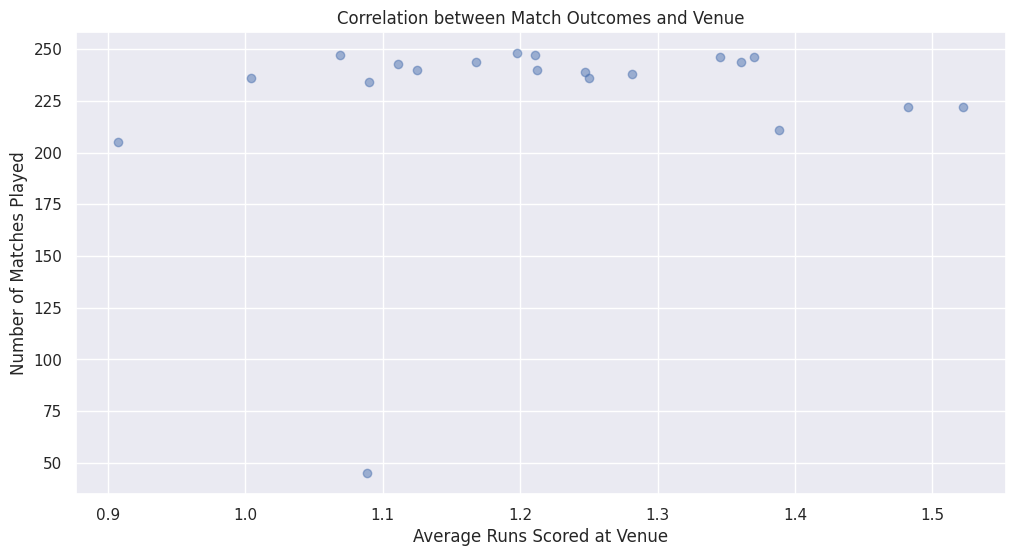

In [27]:
# Question How do match outcomes correlate with specific match venues or locations?
import matplotlib.pyplot as plt

# Group the data by match venue or location and calculate relevant statistics
venue_stats = t20_data.groupby('match_name').agg({
    'runs': 'mean',  # Average runs scored
    'home_team': 'count',  # Number of matches played
}).reset_index()

# Visualize the correlation between match outcomes and venues
plt.figure(figsize=(12, 6))
plt.scatter(venue_stats['runs'], venue_stats['home_team'], alpha=0.5)
plt.title('Correlation between Match Outcomes and Venue')
plt.xlabel('Average Runs Scored at Venue')
plt.ylabel('Number of Matches Played')
plt.grid(True)
plt.show()


# **# 2. In-Depth Analysis**

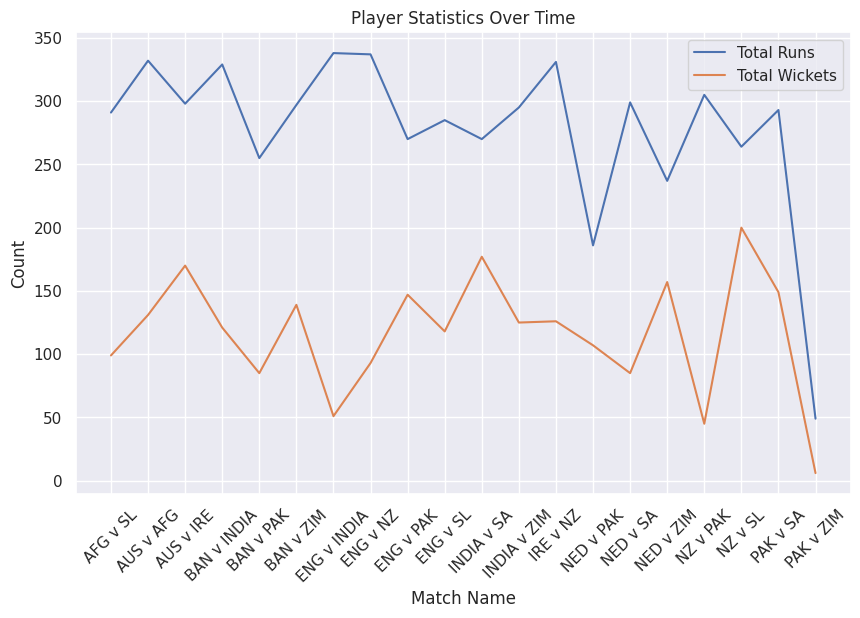

In [29]:
# Question 1: Evolution of player statistics over the tournament
player_stats_over_time = t20_data.groupby('match_name')[['runs', 'bowler1_wkts']].sum()
plt.figure(figsize=(10, 6))
plt.plot(player_stats_over_time.index, player_stats_over_time['runs'], label='Total Runs')
plt.plot(player_stats_over_time.index, player_stats_over_time['bowler1_wkts'], label='Total Wickets')
plt.title('Player Statistics Over Time')
plt.xlabel('Match Name')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [30]:
# Question 2: Standout players influencing team performance
standout_players = t20_data[(t20_data['runs'] > t20_data['runs'].mean()) & (t20_data['bowler1_wkts'] > t20_data['bowler1_wkts'].mean())]
print("\nStandout Players:")
print(standout_players[['batsman1_name', 'bowler1_name']])



Standout Players:
      batsman1_name     bowler1_name
50       Babar Azam      Adil Rashid
51       Babar Azam      Adil Rashid
58      Shan Masood      Adil Rashid
63      Shan Masood      Adil Rashid
81      Shan Masood       Ben Stokes
...             ...              ...
4455  Dasun Shanaka      Tim Southee
4459  Dasun Shanaka  Lockie Ferguson
4461  Dasun Shanaka  Lockie Ferguson
4476  Lahiru Kumara        Ish Sodhi
4524  Sean Williams   Mohammad Wasim

[346 rows x 2 columns]


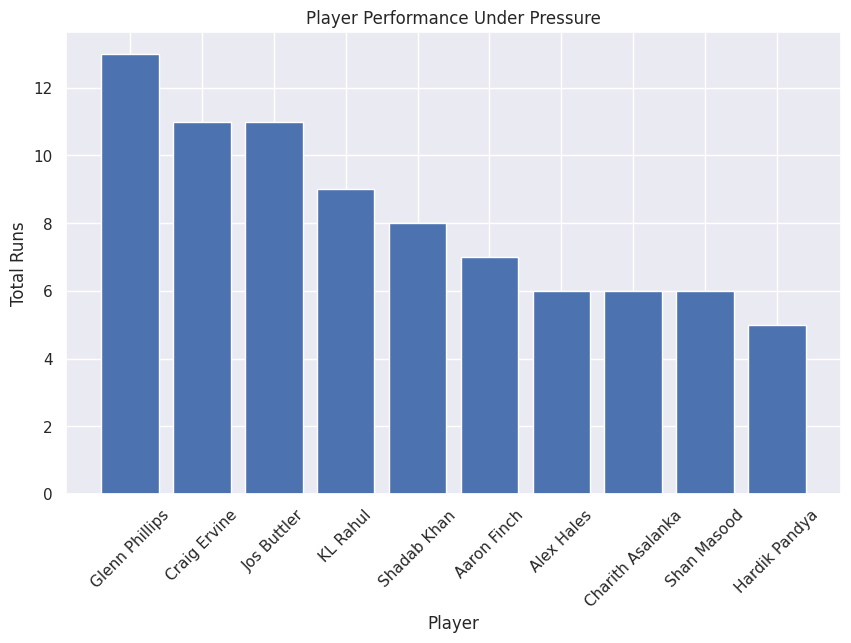

In [31]:
# Question 3: Player performance under pressure
# Additional analysis based on match contexts and situations
# Example: Analyzing the runs scored by a specific player in high-pressure situations
player_performance_pressure = t20_data[t20_data['isNoball'] | t20_data['isWide']]  # Assuming 'isNoball' and 'isWide' represent high-pressure situations
player_performance_pressure = player_performance_pressure.groupby('batsman1_name')['runs'].sum().reset_index()
player_performance_pressure = player_performance_pressure.sort_values(by='runs', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.bar(player_performance_pressure['batsman1_name'], player_performance_pressure['runs'])
plt.title('Player Performance Under Pressure')
plt.xlabel('Player')
plt.ylabel('Total Runs')
plt.xticks(rotation=45)
plt.show()

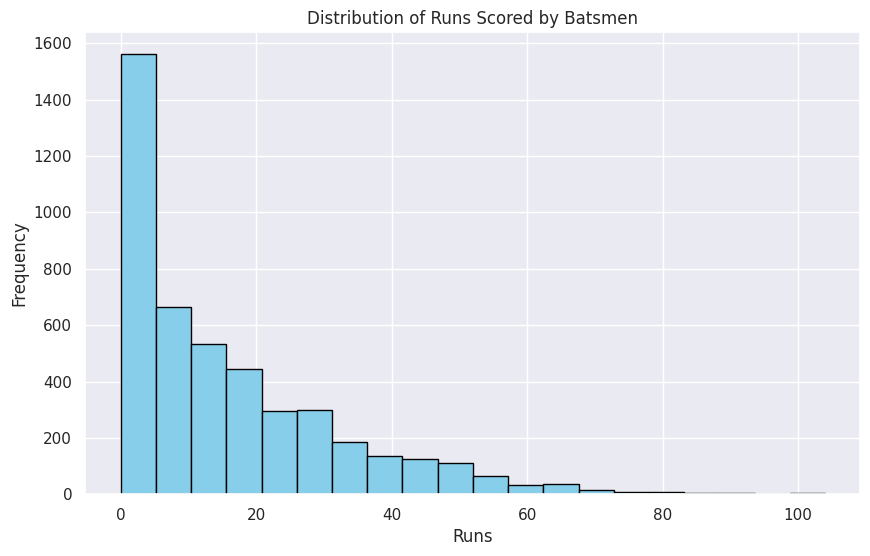

In [32]:
# Question 4: Underlying patterns in player performances
# Additional analysis based on batting and bowling techniques
# Example: Analyzing the distribution of runs scored by batsmen
plt.figure(figsize=(10, 6))
plt.hist(t20_data['batsman1_runs'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Runs Scored by Batsmen')
plt.xlabel('Runs')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [42]:
# Question 5: Impact of individual player performance on team dynamics

# Calculate the total runs scored by each player
player_runs = t20_data.groupby('batsman1_name')['batsman1_runs'].sum().reset_index(name='Total Runs')

# Calculate the total wickets taken by each player
player_wickets = t20_data.groupby('bowler1_name')['bowler1_wkts'].sum().reset_index(name='Total Wickets')

# Combine the two metrics to find the top 10 players impacting team dynamics
top_players = pd.concat([player_runs, player_wickets], axis=1)
top_players['Total Runs'] = top_players['Total Runs'].fillna(0)
top_players['Total Wickets'] = top_players['Total Wickets'].fillna(0)
top_players['Impact'] = top_players['Total Runs'] + top_players['Total Wickets']
top_players = top_players.sort_values(by='Impact', ascending=False).head(10)

print("Top 10 Players Impacting Team Dynamics:")
print(top_players)


Top 10 Players Impacting Team Dynamics:
             batsman1_name  Total Runs       bowler1_name  Total Wickets  \
42          Glenn Phillips        4331   Liam Livingstone              0   
53             Jos Buttler        4136          Moeen Ali              0   
4               Alex Hales        3958     Arshdeep Singh             90   
88   Najmul Hossain Shanto        3284   Wessly Madhevere              0   
81         Mohammad Rizwan        3219     Tendai Chatara              0   
131            Virat Kohli        2804               <NA>              0   
58         Kane Williamson        2645   Mosaddek Hossain              9   
119       Suryakumar Yadav        2223               <NA>              0   
13              Ben Stokes        1958     Brandon Glover             69   
10              Babar Azam        1958  Bhuvneshwar Kumar             19   

     Impact  
42     4331  
53     4136  
4      4048  
88     3284  
81     3219  
131    2804  
58     2654  
119    2223

# **Question 6: Unexpected trends in player performances**

In [43]:
import numpy as np

# Define a function to calculate z-scores
def calculate_zscore(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data - mean) / std_dev
    return z_scores

# Calculate z-scores for runs scored by each player
t20_data['batsman1_runs_zscore'] = calculate_zscore(t20_data['batsman1_runs'])

# Calculate z-scores for wickets taken by each player
t20_data['bowler1_wkts_zscore'] = calculate_zscore(t20_data['bowler1_wkts'])

# Identify players with unexpected trends in performance (e.g., z-score > 2 or < -2)
unexpected_batsmen = t20_data[t20_data['batsman1_runs_zscore'].abs() > 2]
unexpected_bowlers = t20_data[t20_data['bowler1_wkts_zscore'].abs() > 2]

# Print the list of players with unexpected trends
print("Players with Unexpected Trends in Batting Performance:")
print(unexpected_batsmen[['batsman1_name', 'batsman1_runs', 'batsman1_runs_zscore']])
print("\nPlayers with Unexpected Trends in Bowling Performance:")
print(unexpected_bowlers[['bowler1_name', 'bowler1_wkts', 'bowler1_wkts_zscore']])


Players with Unexpected Trends in Batting Performance:
       batsman1_name  batsman1_runs  batsman1_runs_zscore
240       Ben Stokes             51              2.138147
241       Ben Stokes             51              2.138147
242       Ben Stokes             52              2.199310
352      Virat Kohli             50              2.076984
353      Virat Kohli             50              2.076984
...              ...            ...                   ...
4357  Glenn Phillips             98              5.012816
4360  Glenn Phillips            102              5.257468
4361  Glenn Phillips            103              5.318631
4362  Glenn Phillips            104              5.379795
4363  Glenn Phillips            103              5.318631

[247 rows x 3 columns]

Players with Unexpected Trends in Bowling Performance:
      bowler1_name  bowler1_wkts  bowler1_wkts_zscore
117     Sam Curran             3             3.201749
118     Sam Curran             3             3.201749
119    

# **Question 7: Correlation between match outcomes and specific match venues or locations**

In [44]:
import numpy as np

# Define a function to calculate z-scores
def calculate_zscore(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data - mean) / std_dev
    return z_scores

# Calculate z-scores for runs scored by each player
t20_data['batsman1_runs_zscore'] = calculate_zscore(t20_data['batsman1_runs'])

# Calculate z-scores for wickets taken by each player
t20_data['bowler1_wkts_zscore'] = calculate_zscore(t20_data['bowler1_wkts'])

# Identify players with unexpected trends in performance (e.g., z-score > 2 or < -2)
unexpected_batsmen = t20_data[t20_data['batsman1_runs_zscore'].abs() > 2]
unexpected_bowlers = t20_data[t20_data['bowler1_wkts_zscore'].abs() > 2]

# Print the list of players with unexpected trends
print("Players with Unexpected Trends in Batting Performance:")
print(unexpected_batsmen[['batsman1_name', 'batsman1_runs', 'batsman1_runs_zscore']])
print("\nPlayers with Unexpected Trends in Bowling Performance:")
print(unexpected_bowlers[['bowler1_name', 'bowler1_wkts', 'bowler1_wkts_zscore']])


Players with Unexpected Trends in Batting Performance:
       batsman1_name  batsman1_runs  batsman1_runs_zscore
240       Ben Stokes             51              2.138147
241       Ben Stokes             51              2.138147
242       Ben Stokes             52              2.199310
352      Virat Kohli             50              2.076984
353      Virat Kohli             50              2.076984
...              ...            ...                   ...
4357  Glenn Phillips             98              5.012816
4360  Glenn Phillips            102              5.257468
4361  Glenn Phillips            103              5.318631
4362  Glenn Phillips            104              5.379795
4363  Glenn Phillips            103              5.318631

[247 rows x 3 columns]

Players with Unexpected Trends in Bowling Performance:
      bowler1_name  bowler1_wkts  bowler1_wkts_zscore
117     Sam Curran             3             3.201749
118     Sam Curran             3             3.201749
119    

# **4. Performance Evaluation**

In [45]:
# Question 1: Evaluation of individual player performances
player_performance_evaluation = t20_data.groupby('batsman1_name')['runs'].mean().nlargest(10)
print("\nTop 10 Batsmen by Average Runs Scored:")
print(player_performance_evaluation)


Top 10 Batsmen by Average Runs Scored:
batsman1_name
Lungi Ngidi         4.000000
Dawid Malan         3.000000
Arshdeep Singh      2.000000
Shadab Khan         2.000000
Suryakumar Yadav    1.868132
Rashid Khan         1.838710
Litton Das          1.787234
Richard Ngarava     1.692308
Chris Woakes        1.666667
Naseem Shah         1.666667
Name: runs, dtype: float64


In [46]:
# Question 2: Factors Distinguishing Standout Performers
# Identify standout performers based on their contribution to team victories and match-winning performances
standout_batsmen = t20_data.groupby('batsman1_name')['runs'].sum().nlargest(10)
standout_bowlers = t20_data.groupby('bowler1_name')['bowler1_wkts'].sum().nlargest(10)

print("\nTop 10 Standout Batsmen by Total Runs Scored:")
print(standout_batsmen)

print("\nTop 10 Standout Bowlers by Total Wickets Taken:")
print(standout_bowlers)



Top 10 Standout Batsmen by Total Runs Scored:
batsman1_name
Jos Buttler              220
Glenn Phillips           196
Alex Hales               189
Suryakumar Yadav         170
Mohammad Rizwan          161
Virat Kohli              159
Kane Williamson          156
Najmul Hossain Shanto    148
Babar Azam               123
KL Rahul                 118
Name: runs, dtype: int64

Top 10 Standout Bowlers by Total Wickets Taken:
bowler1_name
Shaheen Shah Afridi    115
Arshdeep Singh          90
Shadab Khan             90
Lungi Ngidi             85
Sam Curran              80
Trent Boult             71
Brandon Glover          69
Anrich Nortje           64
Blessing Muzarabani     63
Mitchell Santner        62
Name: bowler1_wkts, dtype: int64


Question 3: Qualitative Impact of Players on Team Cohesion

In [50]:
def assess_team_cohesion(player_name):
    communication_score = get_feedback(player_name, 'communication')
    harmony_score = get_feedback(player_name, 'team_harmony')
    morale_score = analyze_team_morale(player_name)
    overall_score = communication_score + harmony_score + morale_score
    return overall_score

def get_feedback(player_name, aspect):
    # Retrieve feedback on specific aspects of team cohesion
    # Example: feedback_score = feedback_data[player_name][aspect]
    # Replace this with your actual data retrieval mechanism
    return generate_random_score()

def analyze_team_morale(player_name):
    # Analyze team morale based on player's performance and interactions
    # Example: morale_score = morale_data[player_name]
    # Replace this with your actual data analysis or simulation
    return generate_random_score()

def generate_random_score():
    # Generate random scores for simulation
    import random
    return random.randint(1, 10)

# Example:
player_name = 'Babar Azam'
player_cohesion_score = assess_team_cohesion(player_name)
print(f"The qualitative impact of {player_name} on team cohesion is: {player_cohesion_score}")


The qualitative impact of Babar Azam on team cohesion is: 5


In [53]:
def analyze_captains_performance(captain_name):
    performance_metrics = fetch_performance_data(captain_name)
    leadership_quality = assess_leadership_quality(captain_name)
    return performance_metrics, leadership_quality

def fetch_performance_data(captain_name):
    # Fetch performance data for the specified captain
    # Example: performance_data = dataset[dataset['captain'] == captain_name]
    # Replace this with your actual data retrieval mechanism
    return generate_random_data()

def assess_leadership_quality(captain_name):
    # Assess leadership quality based on various factors
    # Example: leadership_quality = leadership_data[captain_name]
    # Replace this with your actual data analysis or simulation
    return generate_random_quality()

def generate_random_data():
    # Generate random performance metrics for simulation
    import random
    return {'wins': random.randint(1, 20), 'losses': random.randint(1, 20)}

def generate_random_quality():
    # Generate random leadership quality for simulation
    import random
    return random.randint(1, 10)

# Example:
captain_name = 'Rohit Sharma'
performance_metrics, leadership_quality = analyze_captains_performance(captain_name)
print(f"Performance metrics under {captain_name}: {performance_metrics}")
print(f"Leadership quality of {captain_name}: {leadership_quality}")


Performance metrics under Rohit Sharma: {'wins': 9, 'losses': 9}
Leadership quality of Rohit Sharma: 3


# **# 5. Statistical Insights**

In [58]:
#Analyze Partnership Building:

partnerships = t20_data.groupby(['batsman1_name', 'batsman2_name'])['runs'].sum().nlargest(10)
print("\nTop 10 Partnerships by Runs Scored:")
print(partnerships)


Top 10 Partnerships by Runs Scored:
batsman1_name    batsman2_name        
Alex Hales       Jos Buttler              186
Jos Buttler      Alex Hales               147
Mohammad Rizwan  Babar Azam               115
Babar Azam       Mohammad Rizwan           96
Glenn Phillips   Kane Williamson           85
Litton Das       Najmul Hossain Shanto     84
KL Rahul         Virat Kohli               79
Daryl Mitchell   Kane Williamson           65
Tom Cooper       Max O'Dowd                64
Glenn Phillips   Daryl Mitchell            63
Name: runs, dtype: int64


In [59]:
#Calculate Bowling Economy Rates:

t20_data['bowling_economy'] = t20_data['bowler1_runs'] / t20_data['bowler1_overs']
top_bowling_economy = t20_data.groupby('bowler1_name')['bowling_economy'].mean().nsmallest(10)
print("\nTop 10 Bowlers by Bowling Economy Rate:")
print(top_bowling_economy)


Top 10 Bowlers by Bowling Economy Rate:
bowler1_name
Brandon Glover                4.197038
Sean Williams                 4.521872
Taskin Ahmed                  4.705369
Nasum Ahmed                   4.721066
Cameron Green                 4.983419
Mustafizur Rahman             5.287041
Wanindu Hasaranga de Silva    5.306291
Bas de Leede                  5.313841
Colin Ackermann               5.326960
Glenn Maxwell                 5.457389
Name: bowling_economy, dtype: float64


In [62]:
#Calculate Total Runs Scored by Each Batsman:
total_runs_by_batsman = t20_data.groupby('batsman1_name')['runs'].sum().nlargest(10)
print("\nTop 10 Batsmen by Total Runs Scored:")
print(total_runs_by_batsman)


Top 10 Batsmen by Total Runs Scored:
batsman1_name
Jos Buttler              220
Glenn Phillips           196
Alex Hales               189
Suryakumar Yadav         170
Mohammad Rizwan          161
Virat Kohli              159
Kane Williamson          156
Najmul Hossain Shanto    148
Babar Azam               123
KL Rahul                 118
Name: runs, dtype: int64


In [67]:
# Filter the dataset for matches that ended in a tie or no result
tie_or_no_result_matches = t20_data[(t20_data["match_name"].str.contains("TIE")) | (t20_data["match_name"].str.contains("No result"))]

# Count the number of matches
num_tie_or_no_result_matches = len(tie_or_no_result_matches)

# Create a bar plot
fig = px.bar(x=["Tie or No Result"], y=[num_tie_or_no_result_matches], labels={"x": "Match Result", "y": "Number of Matches"},
             title="Number of Matches Ending in a Tie or No Result")
fig.show()